# Parámetros

In [1]:
CREDIT_FILE_ID = '18P5oXUpch9s5Nm4WdV_fwjX4oBneyyuh'
APPLICATION_FILE_ID = '1ET5jQSMcLj7odR1OttvR1qdcWtQ-CnaQ'
BASE_DIR = '/Users/efrain.flores/Desktop/EF/EF/UnDosTres/data'
GOT_TIME_TO_TRAIN = False

# Entorno

In [2]:
# Control de datos
from pathlib import Path
from requests import Session
from pickle import dump as save_pkl, load as load_pkl

# Ingeniería de variables
from numpy import nan
from pandas import DataFrame, read_csv, cut, qcut

# Modelos
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# Código

In [3]:
class BussinessCase:
    def __init__(self, base_dir: str=None) -> None:
        '''
        Sólo recibe el directorio de trabajo y la clase cuenta con los métodos suficientes para:
            - limpieza
            - entrenamiento
            - predicción
        '''
        # Define el directorio como objeto Path para manejar eficientemente los archivos y directorios
        if base_dir is not None: self.base_dir = Path(base_dir)
        else: self.base_dir = Path().cwd()
        self.main_dict = {}


    def get_file(self, file_id: str, file_name: str) -> DataFrame:
        '''
        Extrae los archivos via Google Drive
        '''
        # Hace la solicitud a la URL y guarda la respuesta
        session = Session()
        URL = "https://docs.google.com/uc?export=download"
        response = session.get(URL, params={'id':file_id, 'confirm':'t'}, stream=True)

        # Guarda el archivo en el directorio descrito
        file_dir = self.base_dir.joinpath(f'{file_name}.csv')
        with open(file_dir, "wb") as f:
            for chunk in response.iter_content(32768):
                f.write(chunk)

        df = read_csv(file_dir)
        return df

    
    def get_both_files(self, credit_file: tuple, app_file: tuple) -> None:
        self.credit = self.get_file(credit_file[0], credit_file[-1])
        self.app = self.get_file(app_file[0], app_file[-1])
        print(f'Los archivos:\n\t-{credit_file[-1]}.csv\n\t-{app_file[-1]}.csv\nfueron importados exitosamente')


    def mod_credit(self, id_col: str, status_col: str, date_col: str) -> DataFrame:
        cred = self.credit.replace({
            **{'C':'good', 'X':'good', '0':'good'},
            **{str(x):'bad' for x in range(1,6)}
        })
        cred = cred.pivot_table(index=id_col, columns=date_col, values=status_col, aggfunc=lambda x:x)
        cred.fillna('Unknown', inplace=True)
        return cred.astype(str)


    def to_drop(self, df: DataFrame, col: str) -> None:
        df.drop(col, axis=1, inplace=True)
        return df


    def to_range(self, df: DataFrame, col: str, is_train: bool, **kwargs) -> None:
        # Función para convertir float: 1.0 --> str: '01'
        def two_char(n): return str(int(n)).zfill(2)
        # Encontrar el bin al cual el dato pertenece
        if is_train:
            df[col], self.main_dict['ranges'][col] = qcut(df[col], retbins=True, duplicates='drop', **kwargs)
        else: 
            df[col] = cut(df[col], bins=self.main_dict['ranges'][col])
        # Convertirlo a texto: [1.0 - 5.0] --> '01 a 05'
        df[col] = df[col].map(lambda x: two_char(x.left+1)+' a '+two_char(x.right) if x!=nan else nan)
        return df


    def to_flag(self, df: DataFrame, col: str, option_list: list) -> None:
        df[col] = df[col].map(lambda x: 0 if x in option_list else 1)
        return df


    def mod_app(self, id_col: str, to_drop_cols: list, to_range_cols: list, to_flag_cols: list, **kwargs) -> None:
        X = self.app.drop_duplicates(id_col)
        X = X[X[id_col].isin(self.credit[id_col])].copy()
        X.set_index(id_col, inplace=True)

        bc.main_dict['ranges'] = {}
        for col in to_drop_cols: X = self.to_drop(X, col)
        for col in to_range_cols: X = self.to_range(X, col, **kwargs)
        for col, opt in to_flag_cols: X = self.to_flag(X, col, opt)
        return X.astype(str)


    def cm_sklearn(self, X: DataFrame, y: DataFrame, fit_model, target_encoder: LabelEncoder) -> DataFrame:
        '''
        Muestra la matriz de confusión en un mapa de calor
        '''
        # Regresa los números a etiquetas originales
        labels = target_encoder.inverse_transform(fit_model.classes_)
        # Calcula la matriz de confusión, real vs estimado
        cm = DataFrame(confusion_matrix(y_true=y.values, y_pred=fit_model.predict(X)), index=labels, columns=labels).replace({0:nan})
        
        # Define el tamaño de el mapa de calor
        size = len(cm)//1.5
        fig, ax = plt.subplots(figsize=(size, size)) 
        # Crea el mapa de calor con base en la distribución % del valor real a través de sus predicciones
        to_heatmap = DataFrame([cm[col] / cm.sum(axis=1) for col in cm.columns], index=labels, columns=labels).T
        sns.heatmap(to_heatmap, annot=True, fmt='.0%',cmap='Blues', linewidths=0.5, ax=ax, cbar=False)
        plt.show()
        return cm

    
    def save_model(self, model, model_name: str) -> None:
        '''
        Exporta el modelo en modo diccionario para que cuando se importe, se conozca de qué trata el objeto
        '''
        self.models_dir = self.base_dir.joinpath('model')
        self.models_dir.mkdir(exist_ok=True)

        self.main_dict[model_name] = model

        with open(self.models_dir.joinpath(f'{model_name}.xz'), 'wb') as f:
            # Como diccionario para conocer su nombre
            save_pkl(self.main_dict, f)

        print(f'El modelo {model_name}.xz ha sido guardado exitosamente en:\n{self.models_dir}')


    def get_model(self, model_name: str) -> None:
        with open(self.models_dir.joinpath(f'{model_name}.xz'), 'rb') as f:
            # Como diccionario para conocer su nombre
            model_dict = load_pkl(f)
            
        # Confirma que el archivo fue guardado exitosamente
        print(f'El modelo {model_name}.xz fue importado existosamente desde:\n{self.models_dir}')
        return model_dict

# Importar

In [4]:
bc = BussinessCase(BASE_DIR)
bc.get_both_files((CREDIT_FILE_ID, 'credit'), (APPLICATION_FILE_ID, 'app'))

Los archivos:
	-credit.csv
	-app.csv
fueron importados exitosamente


# Transformar

## Clientes

In [5]:
X_pre = bc.mod_app(
    id_col='ID',
    is_train=True,
    to_drop_cols=['FLAG_MOBIL'],
    to_range_cols=['AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS'], q=10,
    to_flag_cols=[
        ('CNT_CHILDREN',['0']),
        ('NAME_HOUSING_TYPE',['House / apartment']),
        ('OCCUPATION_TYPE', [nan])
    ]
)

X_pre.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,
5008804,M,Y,Y,1,315001 a 1575000,Working,Higher education,Civil marriage,1,-13096 a -11822,-5344 a -3596,1,0,0,0,01 a 02
5008805,M,Y,Y,1,315001 a 1575000,Working,Higher education,Civil marriage,1,-13096 a -11822,-5344 a -3596,1,0,0,0,01 a 02
5008806,M,Y,Y,1,90001 a 112500,Working,Secondary / secondary special,Married,0,-22000 a -20295,-1551 a -1081,0,0,0,1,01 a 02
5008808,F,N,Y,1,247501 a 315000,Commercial associate,Secondary / secondary special,Single / not married,0,-20294 a -18614,-3595 a -2755,0,1,1,1,01 a 02
5008809,F,N,Y,1,247501 a 315000,Commercial associate,Secondary / secondary special,Single / not married,0,-20294 a -18614,-3595 a -2755,0,1,1,1,01 a 02


## Historia

In [6]:
y_pre = bc.mod_credit(id_col='ID', status_col='STATUS', date_col='MONTHS_BALANCE')
y_pre.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,good,good,good,good
5001712,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,good,good,good,good,good,good,good,good,good,good
5001713,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,good,good,good,good,good,good,good,good,good,good
5001714,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,good,good,good,good,good,good,good,good,good,good
5001715,Unknown,good,good,good,good,good,good,good,good,good,...,good,good,good,good,good,good,good,good,good,good


# Modelo

## f(X) = y

In [7]:
df = X_pre.join(y_pre)
X = df.loc[:, :-1].copy()
X.columns = list(map(str, X.columns))
X.sample()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
ID,,,,,,,,,,,,,,,,,,,,,
5021791,F,Y,Y,1,139501 a 157500,Working,Secondary / secondary special,Married,0,-15562 a -14355,...,good,good,good,good,good,good,good,good,good,good


In [8]:
y = df[[0]].replace({'Unknown':'good'}).copy()
y[0].value_counts(1, dropna=False)

good    0.991085
bad     0.008915
Name: 0, dtype: float64

## Conjunto validación

In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=False)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Target

In [10]:
from sklearn.preprocessing import LabelEncoder

y_encod = LabelEncoder()
y_train = DataFrame(y_encod.fit_transform(y_train), index=y_train.index)
y_test = DataFrame(y_encod.transform(y_test), index=y_test.index)

/Users/efrain.flores/Desktop/hub/Pruebas/venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/efrain.flores/Desktop/hub/Pruebas/venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Hiperparametrización

In [11]:
from sklearn.linear_model import LogisticRegression

if GOT_TIME_TO_TRAIN:
    from sklearn.metrics import make_scorer, matthews_corrcoef
    from sklearn.model_selection import RandomizedSearchCV

    param_logreg = {
        'penalty':['l1', 'l2'], 
        'C':[x + y/10 for x in range(5) for y in range(1,5)], 
        'class_weight':['balanced'],
        'solver':['liblinear'],
    }
    logreg = RandomizedSearchCV(
        estimator=LogisticRegression(max_iter=1000),
        param_distributions=param_logreg,
        scoring=make_scorer(matthews_corrcoef),
        n_iter=4,
        verbose=1,
        n_jobs=-1
    )

else: logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

## Entrenamiento

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import matthews_corrcoef
from category_encoders.cat_boost import CatBoostEncoder

model = make_pipeline(CatBoostEncoder(), SMOTE(sampling_strategy='minority'), logreg)
model.fit(X_train, y_train.values)
model

Pipeline(steps=[('catboostencoder',
                 CatBoostEncoder(cols=['CODE_GENDER', 'FLAG_OWN_CAR',
                                       'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
                                       'NAME_EDUCATION_TYPE',
                                       'NAME_FAMILY_STATUS',
                                       'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
                                       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
                                       'FLAG_PHONE', 'FLAG_EMAIL',
                                       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
                                       '-60', '-59', '-58', '-57', '-56', '-55',
                                       '-54', '-53', '-52', '-51', '-50', '-49',
                                       '-48', '-47', ...])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

# Resultados

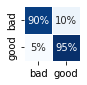

In [13]:
conf = bc.cm_sklearn(X_test, y_test, model, y_encod)

# Exportar modelo

In [14]:
bc.save_model({'model':model, 'encod':y_encod}, model_name='BussinessCase')

El modelo BussinessCase.xz ha sido guardado exitosamente en:
/Users/efrain.flores/Desktop/EF/EF/UnDosTres/data/model


# Importar modelo

In [15]:
ready_to_use = bc.get_model(model_name='BussinessCase')
ready_to_use['BussinessCase']

El modelo BussinessCase.xz fue importado existosamente desde:
/Users/efrain.flores/Desktop/EF/EF/UnDosTres/data/model


{'model': Pipeline(steps=[('catboostencoder',
                  CatBoostEncoder(cols=['CODE_GENDER', 'FLAG_OWN_CAR',
                                        'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                        'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
                                        'NAME_EDUCATION_TYPE',
                                        'NAME_FAMILY_STATUS',
                                        'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
                                        'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
                                        'FLAG_PHONE', 'FLAG_EMAIL',
                                        'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
                                        '-60', '-59', '-58', '-57', '-56', '-55',
                                        '-54', '-53', '-52', '-51', '-50', '-49',
                                        '-48', '-47', ...])),
                 ('smote', SMOTE(sampling_strategy='minority')),
               

# Resumen (por trabajar)

47 ID duplicados con diferentes datos (apenas el 0.01%)
Sólo hay historia de 45985 clientes
Existen 9528 ID con historia pero no están registrados
Clientes registrados y con historia -> 36457 (8.3% de los usuarios únicos registrados)

CODE_GENDER -> cool
FLAG_OWN_CAR -> cool
FLAG_OWN_REALTY -> cool
NAME_INCOME_TYPE -> cool
NAME_EDUCATION_TYPE -> cool
NAME_FAMILY_STATUS -> cool

FLAG_WORK_PHONE -> CAT
FLAG_PHONE -> CAT
FLAG_EMAIL -> CAT

FLAG_MOBIL -> borrar porque todo es 1

AMT_INCOME_TOTAL -> CAT rangos
DAYS_BIRTH -> CAT rangos
DAYS_EMPLOYED -> CAT rangos
CNT_FAM_MEMBERS -> CAT rangos

CNT_CHILDREN -> CAT flag 0 o >0
NAME_HOUSING_TYPE -> CAT flag house?
OCCUPATION_TYPE -> CAT is null?

Clasificación o regresión?
0 -> 1 ?
X, C -> -1 ?
'mean' o 'sum'?